# Configuration

## Imports

In [64]:
# Sentiment and Text Analysis
import newspaper
# import nltk
from textblob import TextBlob
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
import spacy
# General Tools/Utilities
from pathlib import Path
import os
import polars as pl
from multiprocessing import Pool, cpu_count
import re
from typing import List, Tuple
import buckaroo
from tqdm import tqdm
import gc
# Custom Imports
from data_loader import DataLoader


## Supporting Functions

In [65]:
def clean_text(df: pl.DataFrame, text_column) -> pl.DataFrame:
    df = df.with_columns([
        pl.col(text_column)
            .str.to_lowercase()
            .str.replace(r"http\S+", "", literal=False)
            .str.replace(r"[^a-zA-Z\s]", " ", literal=False)
            .str.replace(r"\s+", " ", literal=False)
            .str.strip_chars()
            .alias('cleaned_text')
    ])

    return df

In [66]:
def find_company_symbol(company_name):
    """
    Find the stock symbol for a given company name variation.
    Args:
        company_name (str): Any variation of the company name
        
    Returns:
        str: Stock symbol if found, None otherwise
    """
    company_name_lower = company_name.lower().strip()

    for symbol, name_variations in jse_company_names.items():
        for variation in name_variations:
            if variation.lower() == company_name_lower:
                return symbol

    return None

## Loading Data

In [67]:
loader = DataLoader()

query = """
SELECT 
    trade_date,
    symbol,
    -- open_price,
    daily_range_high,
    daily_range_low,
    closing_price,
    closing_price + price_change as open_price,
    volume
FROM old_trade_data
WHERE trade_date BETWEEN :start_date AND :end_date
ORDER BY trade_date ASC, symbol ASC
"""

# Load all stocks data
stocks_df = loader.fetch_data(
    query=query,
    start_date='2019-01-01',
    end_date='2025-03-31'
)

In [68]:
fileloc = 'C:/Users/Joshh/Projects/Stocks/Data/joined_newspaper_data.parquet'
df = pl.read_parquet(fileloc)

# EDA

In [69]:
df.head(10)

HistogramAnalysis.summary(placeholder['filename'], pd.Series({'min': "Series length 2 doesn't match the DataFrame height of 10", 'max': "Series length 2 doesn't match the DataFrame height of 10", 'value_counts': "Series length 2 doesn't match the DataFrame height of 10", 'length': "Series length 2 doesn't match the DataFrame height of 10", 'unique_count': "Series length 2 doesn't match the DataFrame height of 10", 'is_numeric': "Series length 2 doesn't match the DataFrame height of 10", 'nan_per': "Series length 2 doesn't match the DataFrame height of 10", 'null_count': "Series length 2 doesn't match the DataFrame height of 10", }), placeholder['filename']) # 'str' object has no attribute 'keys'
HistogramAnalysis.summary(placeholder['title'], pd.Series({'min': "Series length 2 doesn't match the DataFrame height of 10", 'max': "Series length 2 doesn't match the DataFrame height of 10", 'value_counts': "Series length 2 doesn't match the DataFrame height of 10", 'length': "Series length 2

Traceback (most recent call last):
  File "c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\buckaroo\pluggable_analysis_framework\polars_analysis_management.py", line 32, in polars_produce_series_df
    result_df = df.lazy().select(all_clauses).collect()
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\polars\_utils\deprecation.py", line 93, in wrapper
    return function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\polars\lazyframe\frame.py", line 2207, in collect
    return wrap_df(ldf.collect(engine, callback))
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
polars.exceptions.ShapeError: Series length 2 doesn't match the DataFrame height of 10


PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

In [70]:
sentiment_df = (
    df
    .select([
        'publication_date',
        'sentiment_polarity', 
        'sentiment_subjectivity',
        'organizations',
        'title'
    ])
    .explode('organizations')  # Creates separate row for each organization
    .with_columns([
        # Clean organization names
        pl.col('organizations').str.strip_chars().str.to_lowercase().alias('institution'),
        # Ensure date is proper datetime
        pl.col('publication_date').alias('date')
    ])
    .filter(
        # Remove empty/null organizations
        pl.col('institution').is_not_null() & 
        (pl.col('institution') != "")
    )
)

In [71]:
def get_company_variations(symbol) -> list:
    """
    Get all name variations for a given stock symbol.
    Args:
        symbol (str): Stock symbol
        
    Returns:
        list: List of all name variations, empty list if symbol not found
    """
    return jse_company_names.get(symbol.upper(), [])

In [72]:
sentiment_df.head(20)

PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

In [73]:
print(f'The Sentiment dataframe has {len(sentiment_df)} rows')
print(f'The combined dataframe has {len(df)} rows')
print(f'The Sentiment dataframe has {len(sentiment_df.select(pl.col('publication_date')).unique())} unique dates')

The Sentiment dataframe has 292028 rows
The combined dataframe has 48582 rows
The Sentiment dataframe has 2743 unique dates


In [74]:
print(f"The sentiment dataframe has {len(sentiment_df.select(pl.col('publication_date')).unique())} unique values")

The sentiment dataframe has 2743 unique values


In [75]:
stocks_df.head(10)

PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

In [76]:
sentiment_df.head(10)

PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

## Data Cleaning
### Text Cleaning
The clean_text function uses regex to clean the text

# Analysis

## Data Integration

The first step is to create a list of all possible names in the Jamaica Stock Exchange to match with newspaper references

In [77]:
jse_company_names = {
# Financial Sector - Main Market
'138SL': ['138SL', '138 Student Living', '138 Student Living Jamaica', '138 Student Living Jamaica Limited', 'Student Living'],
'BIL': ['BIL', 'Barita', 'Barita Investments', 'Barita Investments Limited'],
'CPFV': ['CPFV', 'Eppley Caribbean Property Fund', 'Eppley Caribbean Property Fund Limited', 'ECPF', 'Caribbean Property Fund'],
'EPLY': ['EPLY', 'Eppley', 'Eppley Limited'],
'JSE': ['JSE', 'Jamaica Stock Exchange', 'Stock Exchange'],
'JMMBGL': ['JMMBGL', 'JMMB', 'JMMB Group', 'JMMB Group Limited'],
'NCBFG': ['NCBFG', 'NCB', 'NCB Financial', 'NCB Financial Group', 'NCB Financial Group Limited', 'National Commercial Bank'],
'PROVEN': ['PROVEN', 'Proven', 'Proven Group', 'Proven Group Limited'],
'SGJ': ['SGJ', 'Scotia', 'Scotia Group Jamaica', 'Scotia Group Jamaica Limited', 'Scotiabank Jamaica'],
# Manufacturing Sector - Main Market
'ASBH': ['ASBH', 'A.S. Bryden', 'AS Bryden', 'Bryden', 'A.S. Bryden & Sons', 'A.S. Bryden & Sons Holdings Limited'],
'BRG': ['BRG', 'Berger', 'Berger Paints', 'Berger Paints Jamaica', 'Berger Paints Jamaica Ltd'],
'CCC': ['CCC', 'Caribbean Cement', 'Caribbean Cement Company', 'Caribbean Cement Company Ltd', 'Carib Cement'],
'LASM': ['LASM', 'Lasco', 'Lasco Manufacturing', 'Lasco Manufacturing Limited'],
'SALF': ['SALF', 'Salada', 'Salada Foods', 'Salada Foods Jamaica', 'Salada Foods Jamaica Ltd'],
'SEP': ['SEP', 'Seprod', 'Seprod Limited'],
'WISYNCO': ['WISYNCO', 'Wisynco', 'Wisynco Group', 'Wisynco Group Ltd'],

# Conglomerate Sector - Main Market
'GK': ['GK', 'GraceKennedy', 'Grace Kennedy', 'GraceKennedy Limited'],
'JP': ['JP', 'Jamaica Producers', 'Jamaica Producers Group', 'Jamaica Producers Group Ltd', 'JP Group'],
'PJAM': ['PJAM', 'Pan Jamaica', 'Pan Jamaica Group', 'Pan Jamaica Group Limited'],
'SJ': ['SJ', 'Sagicor', 'Sagicor Jamaica', 'Sagicor Group Jamaica', 'Sagicor Group Jamaica Limited'],

# Financial Sector - Junior Market
'AFS': ['AFS', 'Access Financial', 'Access Financial Services', 'Access Financial Services Limited'],
'ISP': ['ISP', 'ISP Finance', 'ISP Finance Services', 'ISP Finance Services Limited'],
'LASF': ['LASF', 'Lasco Financial', 'Lasco Financial Services', 'Lasco Financial Services Limited'],
'DOLLA': ['DOLLA', 'Dolla', 'Dolla Financial', 'Dolla Financial Services', 'Dolla Financial Services Limited'],

# Manufacturing Sector - Junior Market
'AMG': ['AMG', 'AMG Packaging', 'AMG Packaging & Paper', 'AMG Packaging & Paper Company Limited'],
'BPOW': ['BPOW', 'Blue Power', 'Blue Power Group', 'Blue Power Group Limited'],
'KREMI': ['KREMI', 'Caribbean Cream', 'Caribbean Cream Limited', 'Kremi'],
'CFF': ['CFF', 'Caribbean Flavours', 'Caribbean Flavours & Fragrances', 'Caribbean Flavours & Fragrances Limited', 'Caribbean F&F'],
'PURITY': ['PURITY', 'Consolidated Bakeries', 'Consolidated Bakeries Jamaica', 'Consolidated Bakeries (Jamaica) Limited', 'Purity'],
'HONBUN': ['HONBUN', 'Honey Bun', 'Honey Bun (1982) Limited'],
'JAMT': ['JAMT', 'Jamaican Teas', 'Jamaican Teas Limited', 'Jamaica Teas'],
'OMNI': ['OMNI', 'Omni Industries', 'Omni Industries Limited'],
'PTL': ['PTL', 'Paramount Trading', 'Paramount Trading Jamaica', 'Paramount Trading (Jamaica) Limited'],

# Distribution Sector - Junior Market
'CAC': ['CAC', 'CAC 2000', 'CAC 2000 Limited'],
'DTL': ['DTL', 'Derrimon', 'Derrimon Trading', 'Derrimon Trading Company', 'Derrimon Trading Company Limited'],
'FTNA': ['FTNA', 'Fontana', 'Fontana Limited'],
'INDIES': ['INDIES', 'Indies Pharma', 'Indies Pharma Jamaica', 'Indies Pharma Jamaica Limited'],
'JETCON': ['JETCON', 'Jetcon', 'Jetcon Corporation', 'Jetcon Corporation Limited'],
'MDS': ['MDS', 'Medical Disposables', 'Medical Disposables & Supplies', 'Medical Disposables & Supplies Limited'],
'RPL': ['RPL', 'Regency Petroleum', 'Regency Petroleum Company', 'Regency Petroleum Co. Limited'],

# Technology Sector - Junior Market
'LEARN': ['LEARN', 'Edufocal', 'Edufocal Limited'],
'TTECH': ['TTECH', 'tTech', 'T-Tech', 'tTech Limited'],
'LAB': ['LAB', 'Limners and Bards', 'The Limners and Bards', 'The Limners and Bards Limited'],

# Services Sector - Junior Market
'CABROKERS': ['CABROKERS', 'Caribbean Assurance', 'Caribbean Assurance Brokers', 'Caribbean Assurance Brokers Limited'],
'CHL': ['CHL', 'Cargo Handlers', 'Cargo Handlers Limited'],
'EFRESH': ['EFRESH', 'Everything Fresh', 'Everything Fresh Limited'],
'ECL': ['ECL', 'Express Catering', 'Express Catering Limited'],
'FOSRICH': ['FOSRICH', 'Fosrich', 'Fosrich Company', 'Fosrich Company Limited'],
'GWEST': ['GWEST', 'GWest', 'GWest Corporation', 'GWest Corporation Limited'],
'MAILPAC': ['MAILPAC', 'Mailpac', 'Mailpac Group', 'Mailpac Group Limited'],
'MEEG': ['MEEG', 'Main Event', 'Main Event Entertainment', 'Main Event Entertainment Group'],
'SOS': ['SOS', 'Stationery and Office Supplies', 'Stationery and Office Supplies Limited'],
'SPURTREE': ['SPURTREE', 'Spur Tree', 'Spur Tree Spices', 'Spur Tree Spices Jamaica', 'Spur Tree Spices Jamaica Limited']
}

In [78]:
def integrate_market_sentiment(stocks_df, sentiment_df):
    """
    Fixed integration function with proper literal values
    """
    
    print("Step 1: Adding stock symbols to sentiment data...")
    # Add symbols using your function
    sentiment_with_symbols = sentiment_df.with_columns([
        pl.col('institution').map_elements(find_company_symbol, return_dtype=pl.Utf8).alias('symbol')
    ]).filter(
        pl.col('symbol').is_not_null()  # Keep only mapped institutions
    )
    
    print(f"Kept {sentiment_with_symbols.height} out of {sentiment_df.height} sentiment records")
    
    print("Step 2: Aggregating daily sentiment by company...")
    # Group by date and symbol - handle multiple news per day
    date_col = 'date' if 'date' in sentiment_with_symbols.columns else 'publication_date'
    
    daily_sentiment = (
        sentiment_with_symbols
        .group_by([date_col, 'symbol'])
        .agg([
            pl.col('sentiment_polarity').mean().alias('sentiment'),
            pl.col('sentiment_subjectivity').mean().alias('subjectivity'),
            pl.len().alias('news_count'),  # Fixed: pl.len() instead of pl.count()
            pl.col('title').first().alias('sample_headline')
        ])
        .rename({date_col: 'date'})
    )
    
    print(f"Created {daily_sentiment.height} daily sentiment records")
    
    print("Step 3: Joining with market data...")
    # Join with market data
    integrated = (
        stocks_df
        .rename({'trade_date': 'date'})
        .join(daily_sentiment, on=['date', 'symbol'], how='left')
        .with_columns([
            # Fill missing values
            pl.col('sentiment').fill_null(0.0),
            pl.col('subjectivity').fill_null(0.0), 
            pl.col('news_count').fill_null(0),
            # Add helpful columns - FIXED: Use pl.lit() for literal values
            pl.when(pl.col('news_count') > 0).then(pl.lit(True)).otherwise(pl.lit(False)).alias('has_news'),
            pl.when(pl.col('sentiment') > 0.1).then(pl.lit('Positive'))
            .when(pl.col('sentiment') < -0.1).then(pl.lit('Negative'))
            .otherwise(pl.lit('Neutral')).alias('sentiment_category')
        ])
        .sort(['date', 'symbol'])
    )
    
    return integrated

In [79]:
# ## 4. Run Integration

print("\n" + "="*60)
print("RUNNING INTEGRATION")
print("="*60)

integrated_data = integrate_market_sentiment(stocks_df, sentiment_df)




RUNNING INTEGRATION
Step 1: Adding stock symbols to sentiment data...
Kept 29874 out of 292028 sentiment records
Step 2: Aggregating daily sentiment by company...
Created 12859 daily sentiment records
Step 3: Joining with market data...


In [80]:
# ## 5. Results Summary

print("\n" + "="*60)
print("INTEGRATION RESULTS")
print("="*60)

total_records = integrated_data.height
records_with_news = integrated_data.filter(pl.col('has_news')).height
news_coverage = (records_with_news / total_records) * 100

print(f"Total market records: {total_records:,}")
print(f"Records with news: {records_with_news:,}")
print(f"News coverage: {news_coverage:.1f}% of trading days")

# Date range
date_range = integrated_data.select([
    pl.col('date').min().alias('start_date'),
    pl.col('date').max().alias('end_date')
])
print(f"Date range: {date_range['start_date'][0]} to {date_range['end_date'][0]}")

# Unique symbols with news
symbols_with_news = integrated_data.filter(pl.col('has_news'))['symbol'].n_unique()
total_symbols = integrated_data['symbol'].n_unique()
print(f"Symbols with news: {symbols_with_news}/{total_symbols}")




INTEGRATION RESULTS
Total market records: 184,347
Records with news: 9,416
News coverage: 5.1% of trading days
Date range: 2019-01-02 to 2024-12-24
Symbols with news: 47/263


In [81]:
# ## 6. Quick Data Exploration

print("\nSample of data with news:")
sample_data = (
    integrated_data
    .filter(pl.col('has_news'))
    .select(['date', 'symbol', 'closing_price', 'sentiment', 'news_count', 'sample_headline'])
    .head()
)
print(sample_data)

print("\nTop companies by news volume:")
top_companies = (
    integrated_data
    .filter(pl.col('has_news'))
    .group_by('symbol')
    .agg([
        pl.col('news_count').sum().alias('total_articles'),
        pl.col('sentiment').mean().alias('avg_sentiment'),
        pl.count().alias('days_with_news')
    ])
    .sort('total_articles', descending=True)
    .head(10)
)
display(top_companies)

print("\nSentiment distribution:")
sentiment_distribution = (
    integrated_data
    .filter(pl.col('has_news'))
    .group_by('sentiment_category')
    .agg(pl.count().alias('count'))
    .sort('count', descending=True)
)
display(sentiment_distribution)




Sample of data with news:
shape: (5, 6)
┌────────────┬────────┬───────────────┬───────────┬────────────┬─────────────────────────────────┐
│ date       ┆ symbol ┆ closing_price ┆ sentiment ┆ news_count ┆ sample_headline                 │
│ ---        ┆ ---    ┆ ---           ┆ ---       ┆ ---        ┆ ---                             │
│ date       ┆ str    ┆ decimal[9,2]  ┆ f64       ┆ u32        ┆ str                             │
╞════════════╪════════╪═══════════════╪═══════════╪════════════╪═════════════════════════════════╡
│ 2019-01-02 ┆ JSE    ┆ 9.74          ┆ 0.011481  ┆ 1          ┆ JSE majors down first trading … │
│ 2019-01-02 ┆ NCBFG  ┆ 149.85        ┆ 0.174766  ┆ 2          ┆ Barita up 593% top 2018 JSE st… │
│ 2019-01-02 ┆ SALF   ┆ 31.50         ┆ 0.12634   ┆ 2          ┆ Barita up 593% top 2018 JSE st… │
│ 2019-01-03 ┆ JMMBGL ┆ 33.09         ┆ 0.093067  ┆ 1          ┆ More gains for Trinidad stocks… │
│ 2019-01-03 ┆ JSE    ┆ 10.50         ┆ 0.1057    ┆ 2          ┆ JSE

C:\Users\Joshh\AppData\Local\Temp\ipykernel_26156\4243227311.py:20: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…


Sentiment distribution:


C:\Users\Joshh\AppData\Local\Temp\ipykernel_26156\4243227311.py:32: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

Starting Lag Analysis...
Found integrated_data with 184,347 records
1. Calculating price returns and lag variables...
  - Sorting data by symbol and date...
  - Enhanced dataset created: 184,347 records
2. Analyzing sentiment-return correlations...
  - Analyzing 44 stocks with sufficient news coverage...
3. Creating visualizations...
  - Creating price vs sentiment plots for top 6 stocks...


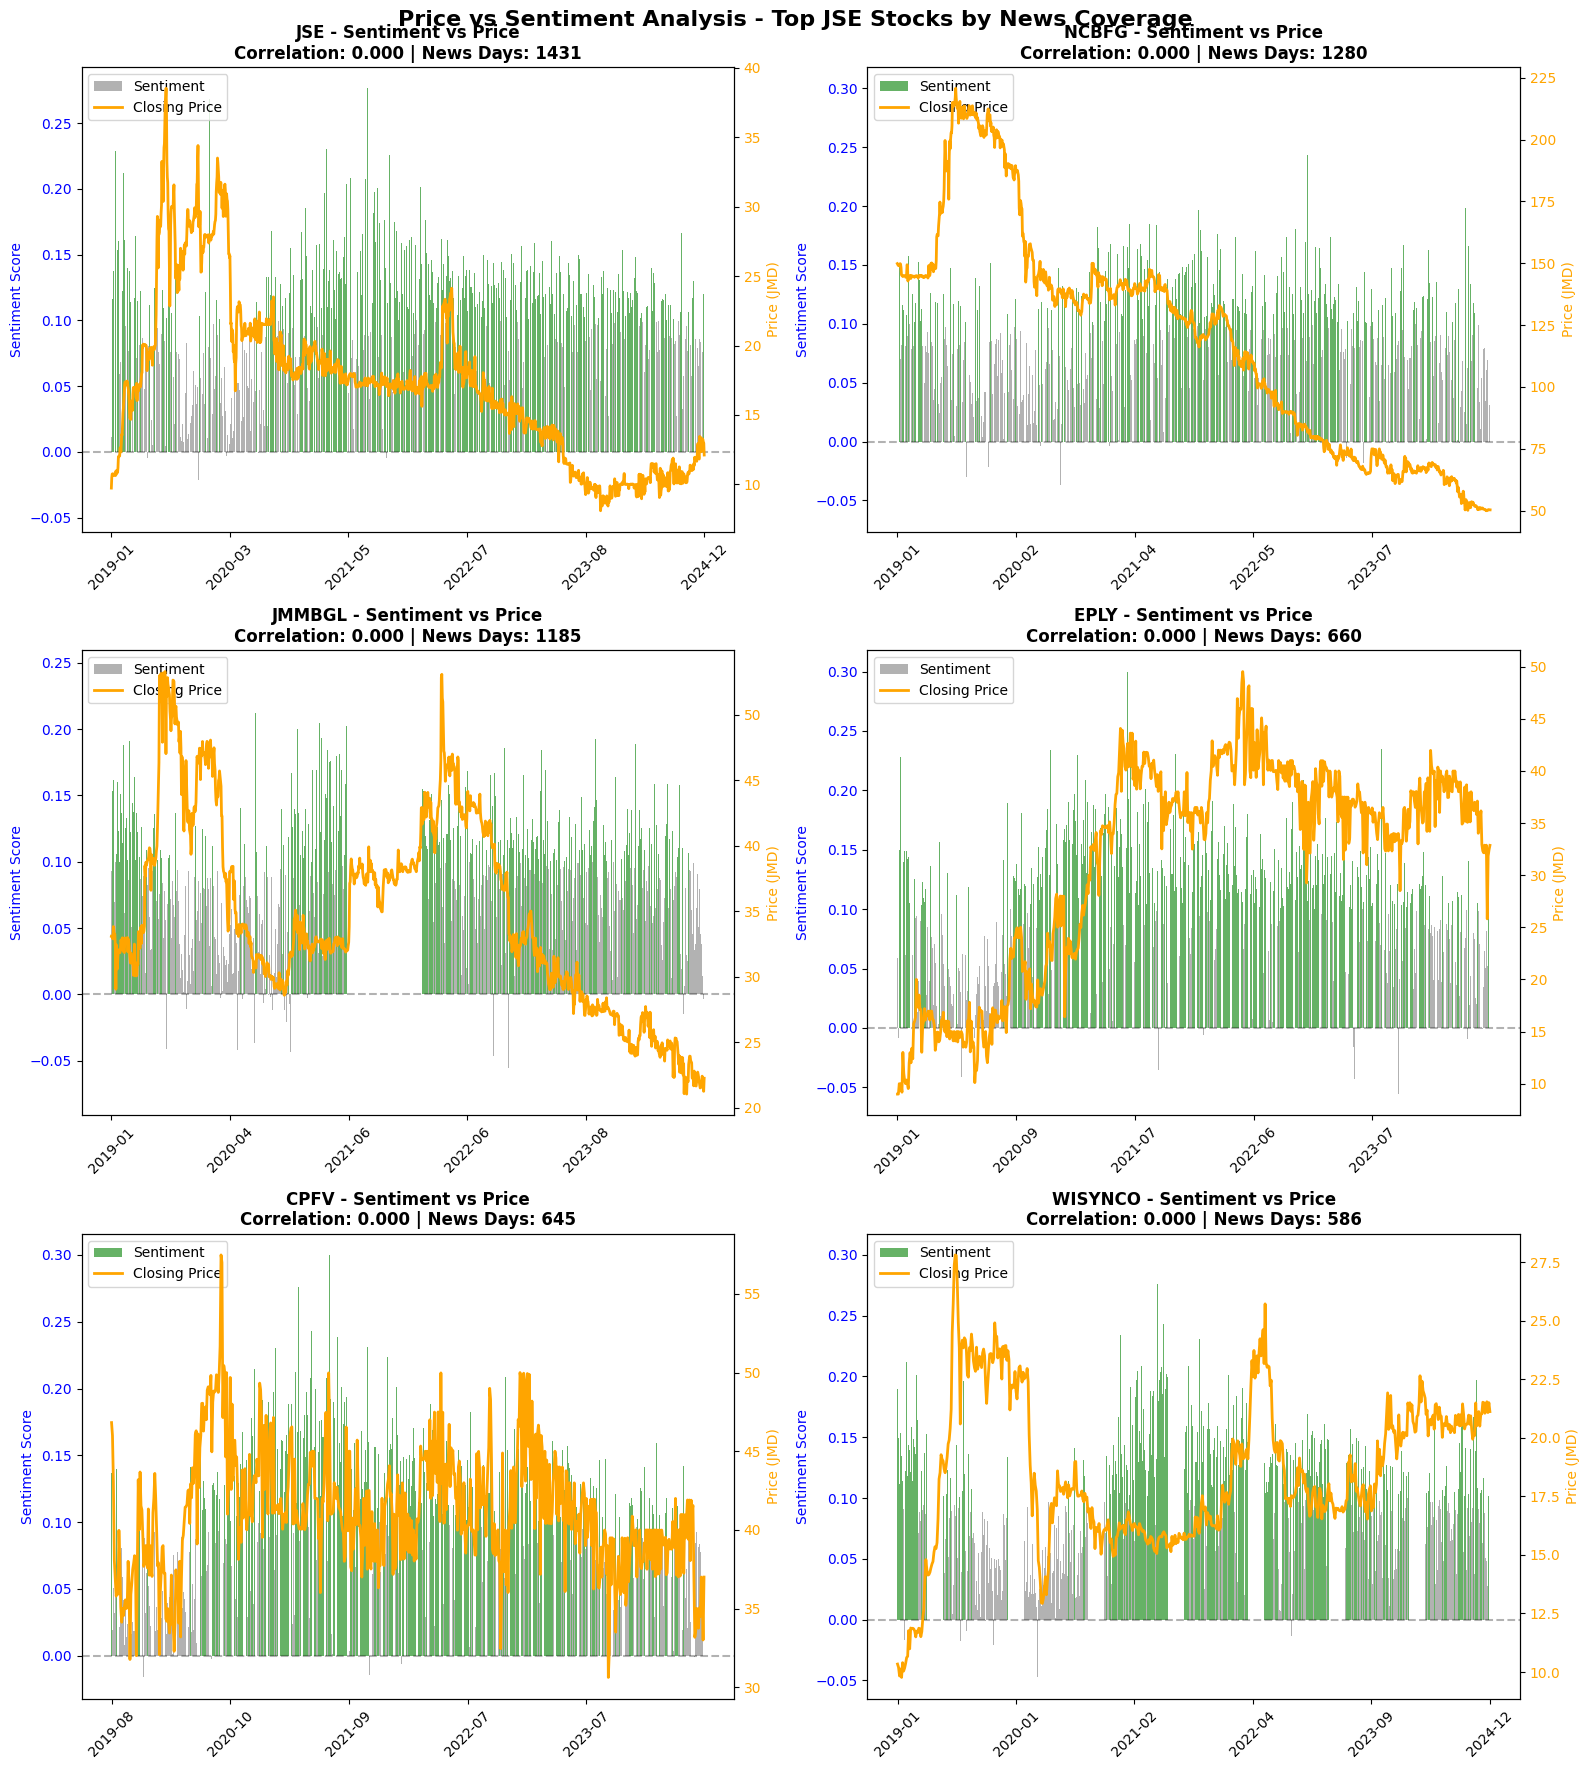

  - Creating correlation heatmap...


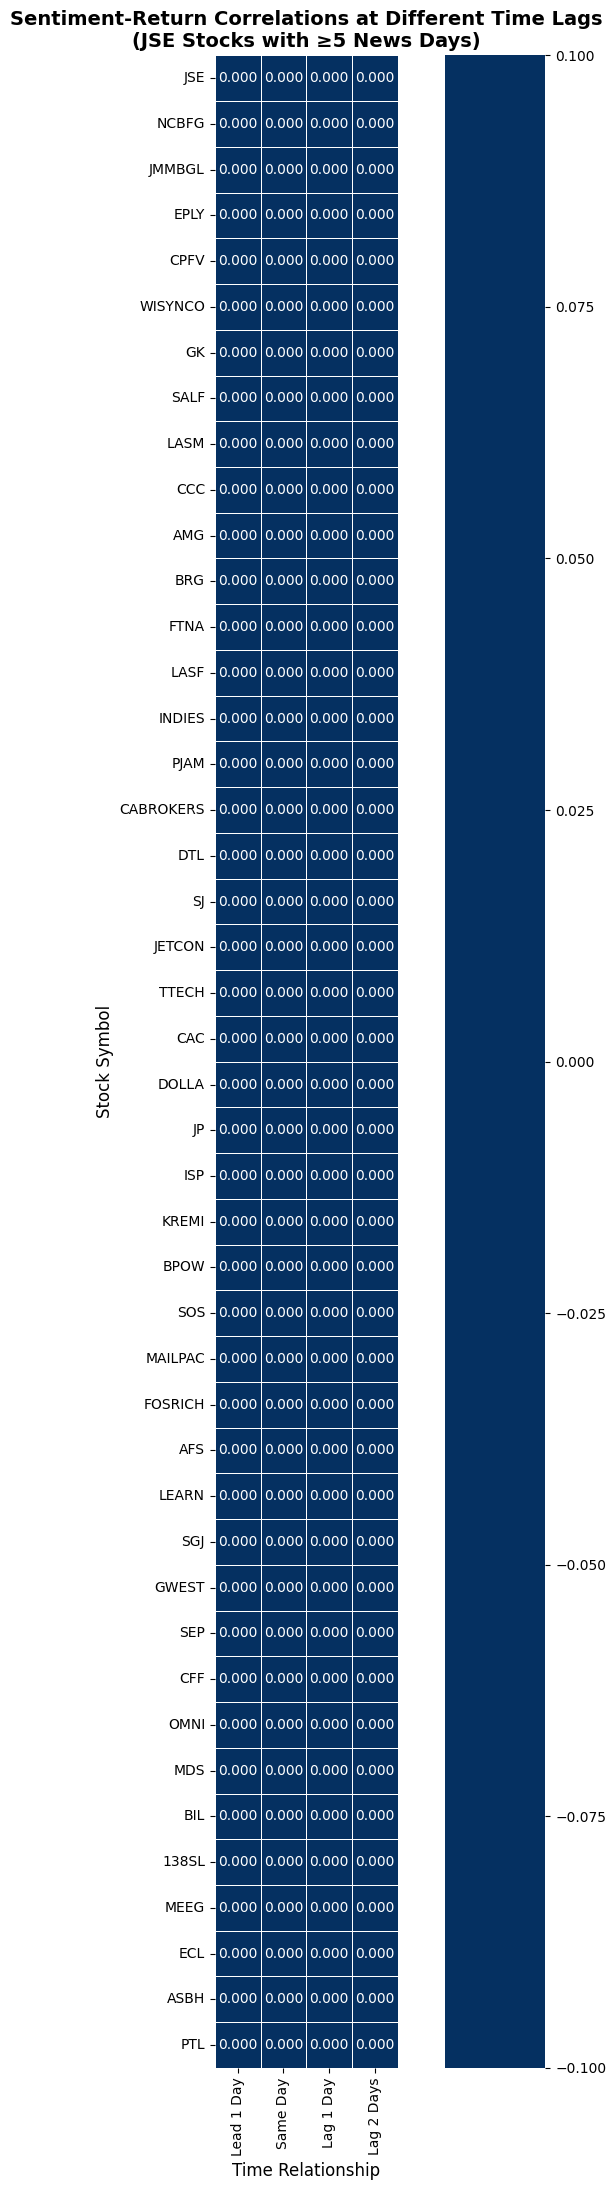


LAG ANALYSIS SUMMARY
Stocks Analyzed: 44
Total News Days: 9409

Average Correlations:
  Lead 1 Day:  0.0000
  Same Day:    0.0000
  Lag 1 Day:   0.0000
  Lag 2 Days:  0.0000

Average Absolute Correlations:
  Same Day:    0.0000
  Lag 1 Day:   0.0000

TOP POSITIVE CORRELATIONS (Same Day)
JSE: 0.0000 (News days: 1431)
NCBFG: 0.0000 (News days: 1280)
JMMBGL: 0.0000 (News days: 1185)
EPLY: 0.0000 (News days: 660)
CPFV: 0.0000 (News days: 645)

STRONGEST LAG-1 EFFECTS
JSE: 0.0000 (News days: 1431)
NCBFG: 0.0000 (News days: 1280)
JMMBGL: 0.0000 (News days: 1185)
EPLY: 0.0000 (News days: 660)
CPFV: 0.0000 (News days: 645)

Lag Analysis Complete!


In [82]:
# =============================================================================
# LAG ANALYSIS SECTION - ADD THIS TO YOUR EXISTING NOTEBOOK
# =============================================================================
# Run this cell after your data integration is complete

# Additional imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def calculate_price_returns(df):
    """
    Calculate daily returns and add lag variables for sentiment analysis
    """
    print("  - Sorting data by symbol and date...")
    
    result = (
        df
        .sort(['symbol', 'date'])
        .with_columns([
            # Calculate daily returns (handle potential division by zero)
            pl.when(pl.col('closing_price').shift(1).over('symbol') > 0)
            .then((pl.col('closing_price') / pl.col('closing_price').shift(1).over('symbol') - 1) * 100)
            .otherwise(0.0)
            .alias('daily_return'),
            
            # Add lag variables for sentiment
            pl.col('sentiment').shift(1).over('symbol').alias('sentiment_lag1'),
            pl.col('sentiment').shift(2).over('symbol').alias('sentiment_lag2'),
            pl.col('sentiment').shift(3).over('symbol').alias('sentiment_lag3'),
            
            # Forward-looking sentiment (for lead analysis)
            pl.col('sentiment').shift(-1).over('symbol').alias('sentiment_lead1'),
            
            # Rolling averages for smoother analysis
            pl.col('sentiment').rolling_mean(window_size=3).over('symbol').alias('sentiment_3day_avg'),
            pl.col('closing_price').rolling_mean(window_size=5).over('symbol').alias('price_5day_avg'),
            
            # Price change indicators
            pl.col('closing_price').shift(1).over('symbol').alias('prev_closing_price'),
            (pl.col('closing_price') - pl.col('closing_price').shift(1).over('symbol')).alias('price_change'),
        ])
        .filter(pl.col('daily_return').is_not_null())  # Remove first day with no return data
    )
    
    print(f"  - Enhanced dataset created: {result.height:,} records")
    return result

def safe_correlation(x_vals, y_vals):
    """
    Calculate correlation with error handling
    """
    try:
        # Remove None/null values
        valid_pairs = [(x, y) for x, y in zip(x_vals, y_vals) if x is not None and y is not None and not np.isnan(x) and not np.isnan(y)]
        
        if len(valid_pairs) < 3:  # Need at least 3 points for correlation
            return 0.0
            
        x_clean, y_clean = zip(*valid_pairs)
        corr, _ = pearsonr(x_clean, y_clean)
        return corr if not np.isnan(corr) else 0.0
    except:
        return 0.0

def analyze_sentiment_correlations(df):
    """
    Calculate correlations between sentiment and price movements at different lags
    """
    correlations = []
    
    # Get stocks with sufficient news coverage
    stocks_with_news = (
        df
        .filter(pl.col('has_news'))
        .group_by('symbol')
        .agg(pl.len().alias('news_days'))
        .filter(pl.col('news_days') >= 5)  # Lowered threshold to 5 days
        .sort('news_days', descending=True)
    )
    
    print(f"  - Analyzing {stocks_with_news.height} stocks with sufficient news coverage...")
    
    for row in stocks_with_news.iter_rows(named=True):
        symbol = row['symbol']
        
        # Get data for this stock with news
        stock_data = (
            df
            .filter((pl.col('symbol') == symbol) & pl.col('has_news'))
            .drop_nulls(['daily_return'])
            .to_pandas()  # Convert to pandas for easier correlation calculation
        )
        
        if len(stock_data) < 5:  # Need minimum data points
            continue
            
        # Calculate correlations using safe function
        correlations.append({
            'symbol': symbol,
            'news_days': row['news_days'],
            'same_day_corr': safe_correlation(stock_data['sentiment'], stock_data['daily_return']),
            'lag1_corr': safe_correlation(stock_data['sentiment_lag1'], stock_data['daily_return']),
            'lag2_corr': safe_correlation(stock_data['sentiment_lag2'], stock_data['daily_return']),
            'lead1_corr': safe_correlation(stock_data['sentiment_lead1'], stock_data['daily_return']),
        })
    
    return pl.DataFrame(correlations)

def plot_price_sentiment_analysis(df, top_stocks=6):
    """
    Create comprehensive visualization of price vs sentiment for top stocks
    """
    print(f"  - Creating price vs sentiment plots for top {top_stocks} stocks...")
    
    # Get top stocks by news coverage
    top_symbols = (
        df
        .filter(pl.col('has_news'))
        .group_by('symbol')
        .agg([
            pl.len().alias('news_days'),
            pl.col('sentiment').mean().alias('avg_sentiment'),
            pl.col('daily_return').mean().alias('avg_return')
        ])
        .filter(pl.col('news_days') >= 5)
        .sort('news_days', descending=True)
        .head(top_stocks)
        .get_column('symbol')
        .to_list()
    )
    
    if len(top_symbols) == 0:
        print("  - No stocks found with sufficient news coverage")
        return
    
    # Create subplots
    rows = (len(top_symbols) + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(16, 6*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle('Price vs Sentiment Analysis - Top JSE Stocks by News Coverage', fontsize=16, fontweight='bold')
    
    for idx, symbol in enumerate(top_symbols):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        # Get stock data with news
        stock_data = (
            df
            .filter((pl.col('symbol') == symbol) & pl.col('has_news'))
            .sort('date')
            .drop_nulls(['daily_return'])
            .to_pandas()
        )
        
        if len(stock_data) == 0:
            ax.text(0.5, 0.5, f'No data for {symbol}', ha='center', va='center', transform=ax.transAxes)
            continue
            
        # Create secondary y-axis for price
        ax2 = ax.twinx()
        
        # Plot sentiment (bars)
        sentiment_colors = ['red' if x < -0.1 else 'green' if x > 0.1 else 'gray' for x in stock_data['sentiment']]
        ax.bar(range(len(stock_data)), stock_data['sentiment'], alpha=0.6, color=sentiment_colors, label='Sentiment')
        ax.set_ylabel('Sentiment Score', color='blue')
        ax.tick_params(axis='y', labelcolor='blue')
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        
        # Plot price (line)
        ax2.plot(range(len(stock_data)), stock_data['closing_price'], color='orange', linewidth=2, label='Closing Price')
        ax2.set_ylabel('Price (JMD)', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        
        # Calculate correlation
        corr = safe_correlation(stock_data['sentiment'], stock_data['daily_return'])
        
        # Set title with correlation
        ax.set_title(f'{symbol} - Sentiment vs Price\nCorrelation: {corr:.3f} | News Days: {len(stock_data)}', 
                    fontweight='bold')
        
        # Format x-axis (show every 5th date for readability)
        if len(stock_data) > 10:
            tick_indices = range(0, len(stock_data), max(1, len(stock_data)//5))
            ax.set_xticks(tick_indices)
            ax.set_xticklabels([stock_data.iloc[i]['date'].strftime('%Y-%m') for i in tick_indices], rotation=45)
        
        # Add legend
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Hide empty subplots
    for idx in range(len(top_symbols), rows * 2):
        row = idx // 2
        col = idx % 2
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(correlations_df):
    """
    Create heatmap showing correlations at different lags
    """
    print("  - Creating correlation heatmap...")
    
    if correlations_df.height == 0:
        print("    No correlation data available for heatmap")
        return
        
    # Prepare data for heatmap
    corr_data = correlations_df.select([
        'symbol', 'lead1_corr', 'same_day_corr', 'lag1_corr', 'lag2_corr'
    ]).to_pandas().set_index('symbol')
    
    # Rename columns for clarity
    corr_data.columns = ['Lead 1 Day', 'Same Day', 'Lag 1 Day', 'Lag 2 Days']
    
    # Create heatmap
    plt.figure(figsize=(10, max(6, len(corr_data) * 0.5)))
    sns.heatmap(corr_data, annot=True, cmap='RdBu_r', center=0, 
                fmt='.3f', square=True, linewidths=0.5)
    plt.title('Sentiment-Return Correlations at Different Time Lags\n(JSE Stocks with ≥5 News Days)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Time Relationship', fontsize=12)
    plt.ylabel('Stock Symbol', fontsize=12)
    plt.tight_layout()
    plt.show()

def create_summary_statistics(correlations_df):
    """
    Generate summary statistics for lag analysis
    """
    if correlations_df.height == 0:
        print("No correlation data available for summary")
        return
        
    summary = correlations_df.select([
        pl.col('same_day_corr').mean().alias('avg_same_day'),
        pl.col('lag1_corr').mean().alias('avg_lag1'),
        pl.col('lag2_corr').mean().alias('avg_lag2'),
        pl.col('lead1_corr').mean().alias('avg_lead1'),
        pl.col('same_day_corr').abs().mean().alias('avg_abs_same_day'),
        pl.col('lag1_corr').abs().mean().alias('avg_abs_lag1'),
        pl.col('news_days').sum().alias('total_news_days'),
        pl.len().alias('stocks_analyzed')
    ])
    
    print("\n" + "="*60)
    print("LAG ANALYSIS SUMMARY")
    print("="*60)
    
    for row in summary.iter_rows(named=True):
        print(f"Stocks Analyzed: {row['stocks_analyzed']}")
        print(f"Total News Days: {row['total_news_days']}")
        print(f"\nAverage Correlations:")
        print(f"  Lead 1 Day:  {row['avg_lead1']:.4f}")
        print(f"  Same Day:    {row['avg_same_day']:.4f}")
        print(f"  Lag 1 Day:   {row['avg_lag1']:.4f}")
        print(f"  Lag 2 Days:  {row['avg_lag2']:.4f}")
        print(f"\nAverage Absolute Correlations:")
        print(f"  Same Day:    {row['avg_abs_same_day']:.4f}")
        print(f"  Lag 1 Day:   {row['avg_abs_lag1']:.4f}")

# =============================================================================
# EXECUTE LAG ANALYSIS
# =============================================================================

print("Starting Lag Analysis...")
print("="*50)

# Check if integrated_data exists
try:
    print(f"Found integrated_data with {integrated_data.height:,} records")
except NameError:
    print("ERROR: integrated_data not found. Please run the data integration section first.")
    print("Make sure you have run the earlier cells that create the integrated_data variable.")
else:
    # Step 1: Calculate returns and lag variables
    print("1. Calculating price returns and lag variables...")
    enhanced_data = calculate_price_returns(integrated_data)
    
    # Step 2: Analyze correlations
    print("2. Analyzing sentiment-return correlations...")
    correlations = analyze_sentiment_correlations(enhanced_data)
    
    # Step 3: Create visualizations
    print("3. Creating visualizations...")
    plot_price_sentiment_analysis(enhanced_data, top_stocks=6)
    plot_correlation_heatmap(correlations)
    
    # Step 4: Generate summary statistics
    create_summary_statistics(correlations)
    
    # Step 5: Show top/bottom correlations
    if correlations.height > 0:
        print("\n" + "="*60)
        print("TOP POSITIVE CORRELATIONS (Same Day)")
        print("="*60)
        top_positive = correlations.sort('same_day_corr', descending=True).head(5)
        for row in top_positive.iter_rows(named=True):
            print(f"{row['symbol']}: {row['same_day_corr']:.4f} (News days: {row['news_days']})")
        
        print("\n" + "="*60)  
        print("STRONGEST LAG-1 EFFECTS")
        print("="*60)
        strongest_lag = correlations.filter(pl.col('lag1_corr').is_not_null()).sort('lag1_corr', descending=True).head(5)
        for row in strongest_lag.iter_rows(named=True):
            print(f"{row['symbol']}: {row['lag1_corr']:.4f} (News days: {row['news_days']})")
    
    print("\nLag Analysis Complete!")
    print("="*50)

In [83]:
integrated_data.head(10)

PolarsBuckarooWidget(buckaroo_options={'sampled': ['random'], 'auto_clean': ['aggressive', 'conservative'], 'p…

In [86]:
print(f"The total unique sentiments is {len(integrated_data.select('sentiment').unique())} ")

The total unique sentiments is 5491 


The total number of days

In [85]:
print(365 * 4 * 44)

64240
